In [1]:
import os
import sys

os.chdir("..")
sys.path.append("..")

In [2]:
from copy import deepcopy
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import TrainDataLoader, ValidationDataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.time_feature import (
    HourOfDay,
    DayOfWeek,
    DayOfMonth,
    DayOfYear,
    MonthOfYear
)
from gluonts.torch.batchify import batchify
from gluonts.transform import (
    AddObservedValuesIndicator,
    AddTimeFeatures,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    ValidationSplitSampler
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm


from src.app.utils import get_prediction_dataloader
from src.utils.data_loading import load_features, load_score, load_test_data, load_train_data
from src.utils.features import trend_determination, trend_slope, trend_linearity, seasonal_determination, decomps_and_features, extract_trend
from src.utils.transformations import manipulate_trend_component, manipulate_seasonal_determination

/anaconda/envs/whatif/lib/python3.8/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
model_name = "nbeats_g"
dataset_name = "m4_monthly"

datadir = f"data/{dataset_name}"
experiment_dir = f"experiments/{dataset_name}/{model_name}"

In [4]:
dataset = get_dataset(dataset_name)
dataset = ListDataset(dataset.train, freq=dataset.metadata.freq)

In [5]:
train_data = []
for ts in dataset:
    train_data.append(ts["target"])

len(train_data)

48000

In [6]:
_, features = decomps_and_features(train_data, sp=24)

In [8]:
train_features = np.load("../data/m4_monthly/master/reprod/orig_train_features.npy")
test_features = np.load("../data/m4_monthly/master/reprod/orig_test_features.npy")

scaler = StandardScaler()
norm_train_features = scaler.fit_transform(train_features)
norm_test_features = scaler.transform(test_features)


pca = PCA(n_components=2)
train_pca_data = pca.fit_transform(norm_train_features)
test_pca_data = pca.transform(norm_test_features)

norm_full_length_features = scaler.transform(features)
full_length_pca_data = pca.transform(norm_full_length_features)

(-5.0, 6.0)

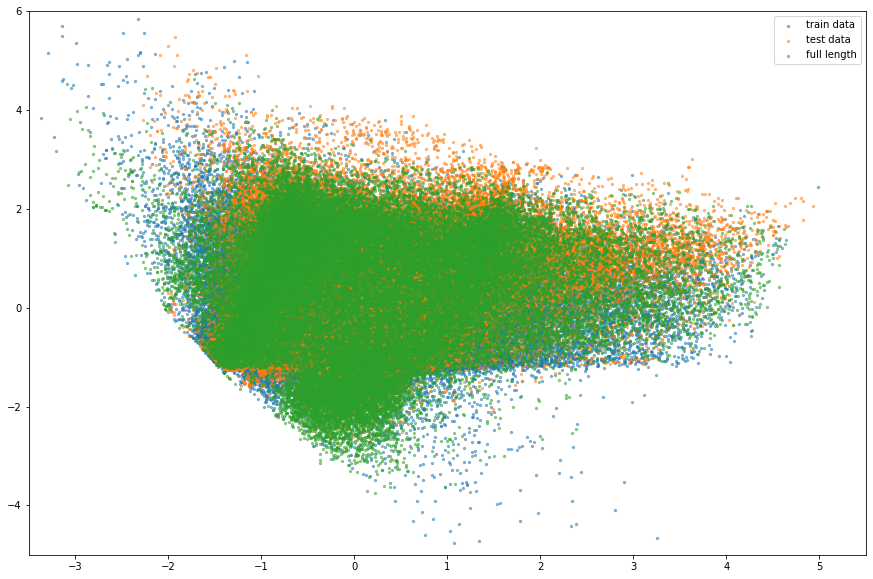

In [9]:
plt.figure(figsize=(15, 10))

plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=0.5)
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=0.5)
plt.scatter(full_length_pca_data[:, 0], full_length_pca_data[:, 1], label="full length", s=5, alpha=0.5)
plt.legend()
plt.xlim([-3.5, 5.5])
plt.ylim([-5, 6])

In [10]:
filtered_full_length = full_length_pca_data[full_length_pca_data[:, 0] > 2]
filtered_full_length.shape

(3368, 2)

(-5.0, 6.0)

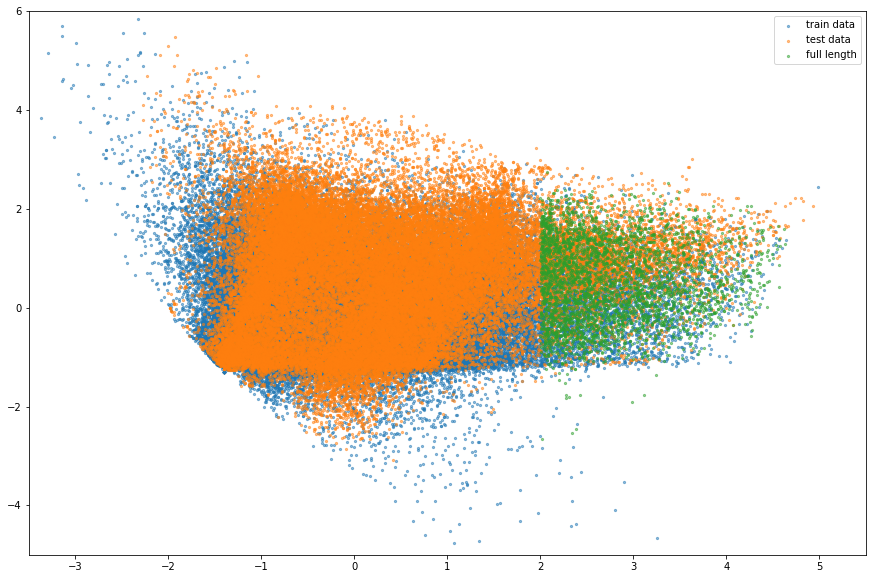

In [11]:
plt.figure(figsize=(15, 10))

plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=0.5)
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=0.5)
plt.scatter(filtered_full_length[:, 0], filtered_full_length[:, 1], label="full length", s=5, alpha=0.5)
plt.legend()
plt.xlim([-3.5, 5.5])
plt.ylim([-5, 6])

In [12]:
mask = full_length_pca_data[:, 0] > 2
mask.shape

(48000,)

In [13]:
new_list_data = []
for (m, entry) in zip(mask, dataset.list_data):
    if m:
        new_list_data.append(deepcopy(entry))

len(new_list_data)

3368

In [14]:
new_dataset = ListDataset(new_list_data, freq=dataset.list_data[0]["start"].freq)

In [15]:
def create_train_dataloader(dataset, context_length, prediction_length, batch_size, num_batches_per_epoch):
    transformation = Chain([
        AddObservedValuesIndicator(
            target_field=FieldName.TARGET,
            output_field=FieldName.OBSERVED_VALUES,
        ),
        AddTimeFeatures(
            start_field=FieldName.START,
            target_field=FieldName.TARGET,
            output_field=FieldName.FEAT_TIME,
            pred_length=prediction_length,
            time_features=[HourOfDay(), DayOfWeek(), DayOfMonth(), DayOfYear(), MonthOfYear()]
        ),
        InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(num_instances=1, min_past=context_length,
                                                        min_future=prediction_length),
            past_length=context_length,
            future_length=prediction_length,
            time_series_fields=[FieldName.FEAT_TIME, FieldName.OBSERVED_VALUES]
        )
    ])
    dataloader = TrainDataLoader(
        dataset,
        batch_size=batch_size,
        stack_fn=batchify,
        transform=transformation,
        num_batches_per_epoch=num_batches_per_epoch,
        num_workers=1
    )
    return dataloader

In [16]:
dataloader = create_train_dataloader(new_dataset, config["context_length"], config["prediction_length"], config["trainer_args"]["batch_size"],
                                     config["trainer_args"]["num_batches_per_epoch"])

In [17]:
def sample_and_plot_from_dataloader(dataloader, sp, scaler, pca, train_pca_data, test_pca_data, num_samples=20000, lim=True):
    sampled_series = []
    for batch in dataloader:
        data = torch.cat([batch["past_target"], batch["future_target"]], dim=-1)
        for ts in data:
            sampled_series.append(ts)

        if len(sampled_series) > num_samples:
            break

    _, sampled_features = decomps_and_features(sampled_series, sp)
    sampled_scaled_features = scaler.transform(sampled_features)
    sampled_pca_data = pca.transform(sampled_scaled_features)

    plt.figure(figsize=(15, 10))
    
    if train_pca_data is not None:
        plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=.1)
    if test_pca_data is not None:
        plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=.1)
    
    plt.scatter(sampled_pca_data[:, 0], sampled_pca_data[:, 1], label="transformed train data", s=5, alpha=.1)
    plt.legend()
    
    if lim:
        plt.xlim([-3.5, 5.5])
        plt.ylim([-5, 6])
    
    return sampled_series, sampled_pca_data

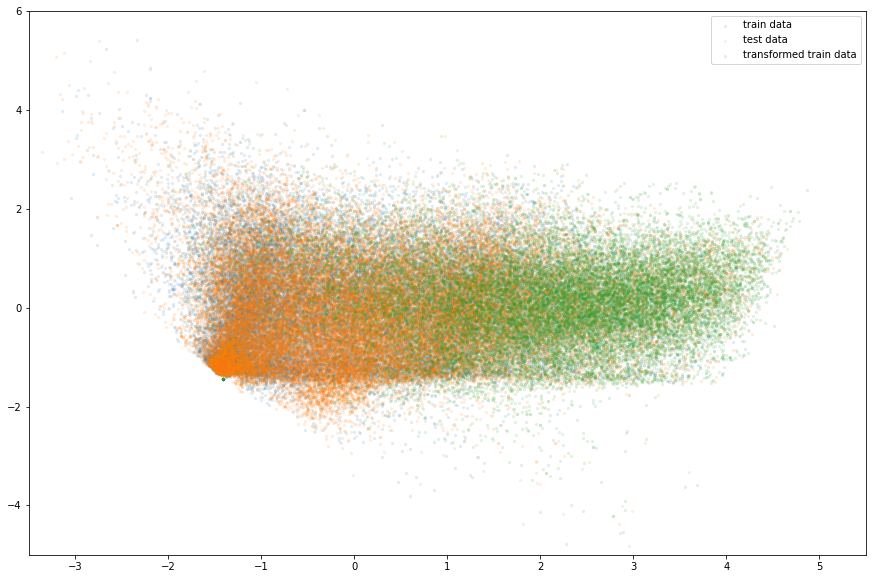

In [18]:
_, sampled_pca_data = sample_and_plot_from_dataloader(dataloader, config["sp"], scaler, pca, train_pca_data, test_pca_data)

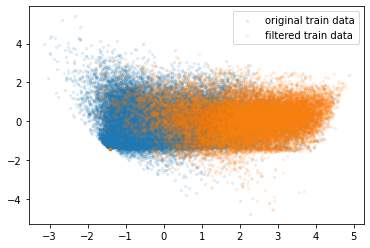

In [19]:
plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="original train data", s=5, alpha=.1)
plt.scatter(sampled_pca_data[:, 0], sampled_pca_data[:, 1], label="filtered train data", s=5, alpha=.1)
plt.legend()

In [20]:
def create_validation_dataloader(dataset, context_length, prediction_length, batch_size, num_batches_per_epoch):
    transformation = Chain([
        AddObservedValuesIndicator(
            target_field=FieldName.TARGET,
            output_field=FieldName.OBSERVED_VALUES,
        ),
        AddTimeFeatures(
            start_field=FieldName.START,
            target_field=FieldName.TARGET,
            output_field=FieldName.FEAT_TIME,
            pred_length=prediction_length,
            time_features=[HourOfDay(), DayOfWeek(), DayOfMonth(), DayOfYear(), MonthOfYear()]
        ),
        InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ValidationSplitSampler(min_future=prediction_length),
            past_length=context_length,
            future_length=prediction_length,
            time_series_fields=[FieldName.FEAT_TIME, FieldName.OBSERVED_VALUES]
        )
    ])
    dataloader = ValidationDataLoader(
        dataset,
        batch_size=batch_size,
        stack_fn=batchify,
        transform=transformation,
        num_workers=1
    )
    return dataloader

In [21]:
def get_train_and_val_data(train_data, num_validation_windows, context_length, prediction_length, freq):
    validation_data = []
    for i in range(num_validation_windows):
        for ts in train_data.list_data:
            # only add time series long enough that we can remove one horizon and still have context_length +
            # prediction_length values left
            if len(ts["target"]) <= context_length + prediction_length * (i + 2):
                continue

            val_ts = deepcopy(ts)
            val_ts["target"] = val_ts["target"][:-prediction_length * i if i > 0 else None]
            val_ts["target"] = val_ts["target"][-(context_length + prediction_length):]
            validation_data.append(val_ts)

            # slice off the validation data from the training data
            if i == num_validation_windows - 1:
                ts["target"] = ts["target"][:-prediction_length * (i + 1)]
    
    return train_data, ListDataset(validation_data, freq=freq)

In [22]:
def add_to_dataset(original_data, generated_data):
    for i, ts in enumerate(generated_data, start=len(original_data)):
        entry = {"start": ts.index[0], "target": ts.values, "feat_static_cat": np.array([i]), "item_id": i}
        original_data.list_data.append(entry)
    
    return original_data


def change_trend_lin(data, sp, h):
    generated = []
    for i, ts in tqdm(enumerate(data)):
        index = pd.date_range(start=ts["start"], freq=ts["start"].freq, periods=len(ts["target"]))
        ts = pd.Series(data=ts["target"], index=index)
        if sp > 1:
            decomp = STL(ts, period=sp).fit()
        else:
            decomp = extract_trend(ts)
        
        new_trend = manipulate_trend_component(decomp.trend, f=1, g=1, h=h, m=0)
        new_ts = new_trend + decomp.seasonal + decomp.resid
        generated.append(new_ts)
    
    return generated


def change_trend_str(data, sp, f):
    generated = []
    for i, ts in tqdm(enumerate(data)):
        index = pd.date_range(start=ts["start"], freq=ts["start"].freq, periods=len(ts["target"]))
        ts = pd.Series(data=ts["target"], index=index)
        if sp > 1:
            decomp = STL(ts, period=sp).fit()
        else:
            decomp = extract_trend(ts)
        
        new_trend = manipulate_trend_component(decomp.trend, f=f, g=1, h=1, m=0)
        new_ts = new_trend + decomp.seasonal + decomp.resid
        generated.append(new_ts)
    
    return generated


def change_trend_slope(data, sp, m):
    generated = []
    for i, ts in tqdm(enumerate(data)):
        index = pd.date_range(start=ts["start"], freq=ts["start"].freq, periods=len(ts["target"]))
        ts = pd.Series(data=ts["target"], index=index)
        if sp > 1:
            decomp = STL(ts, period=sp).fit()
        else:
            decomp = extract_trend(ts)
        
        new_trend = manipulate_trend_component(decomp.trend, f=1, g=1, h=1, m=m)
        new_ts = new_trend + decomp.seasonal + decomp.resid
        generated.append(new_ts)
    
    return generated


def change_seas_str(data, sp, k):
    generated = []
    for i, ts in tqdm(enumerate(data)):
        index = pd.date_range(start=ts["start"], freq=ts["start"].freq, periods=len(ts["target"]))
        ts = pd.Series(data=ts["target"], index=index)
        if sp > 1:
            decomp = STL(ts, period=sp).fit()
        else:
            decomp = extract_trend(ts)
        
        new_season= manipulate_seasonal_determination(decomp.seasonal, k=k)
        new_ts = decomp.trend + new_season + decomp.resid
        generated.append(new_ts)
    
    return generated

In [23]:
def transform_data(data, sp, f=1, h=1, k=1, m=0):
    generated = []
    for i, ts in tqdm(enumerate(data)):
        index = pd.date_range(start=ts["start"], freq=ts["start"].freq, periods=len(ts["target"]))
        ts = pd.Series(data=ts["target"], index=index)
        if sp > 1:
            decomp = STL(ts, period=sp).fit()
        else:
            decomp = extract_trend(ts)
        
        new_trend = manipulate_trend_component(decomp.trend, f=f, g=1, h=h, m=m / len(ts))
        new_season= manipulate_seasonal_determination(decomp.seasonal, k=k)
        new_ts = new_trend + new_season + decomp.resid
        generated.append(new_ts)
    
    return generated

In [24]:
new_dataset = ListDataset(new_list_data, freq=dataset.list_data[0]["start"].freq)
train_data, validation_data = get_train_and_val_data(new_dataset, 1, config["trainer_args"]["context_length"],
                                                     config["trainer_args"]["prediction_length"], freq=dataset.list_data[0]["start"].freq)

In [25]:
generated_train = transform_data(new_dataset, config["sp"], m=1.5, k=1.5)
expanded_train = add_to_dataset(new_dataset, generated_train)

3419it [00:23, 145.47it/s]


In [26]:
generated_val = transform_data(validation_data, config["sp"], m=0.5, k=1.5)
expanded_val = add_to_dataset(validation_data, generated_val)

2127it [00:09, 219.23it/s]


In [27]:
train_dataloader = create_train_dataloader(expanded_train, config["trainer_args"]["context_length"], config["trainer_args"]["prediction_length"],
                                           config["trainer_args"]["batch_size"], config["trainer_args"]["num_batches_per_epoch"])

validation_dataloader = create_validation_dataloader(expanded_val, config["trainer_args"]["context_length"], config["trainer_args"]["prediction_length"],
                                                     config["trainer_args"]["batch_size"], config["trainer_args"]["num_batches_per_epoch"])

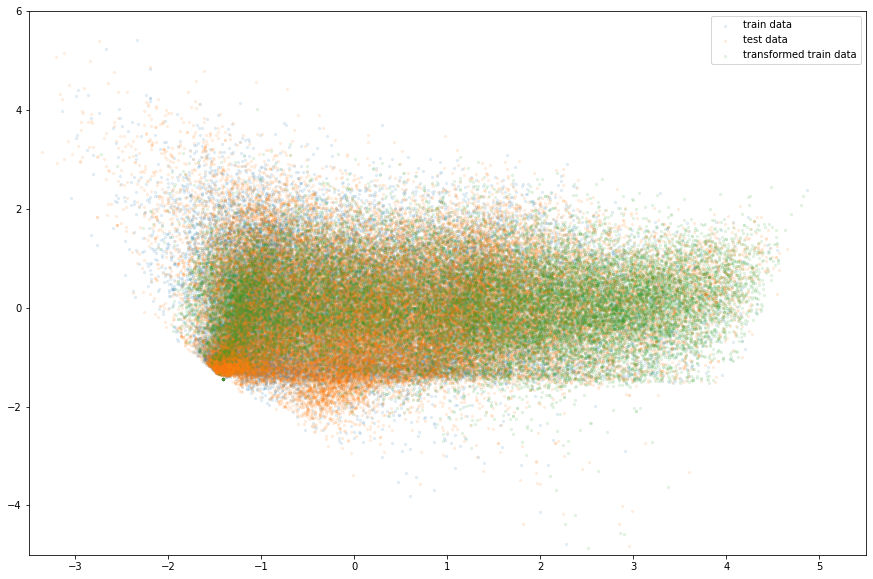

In [28]:
_, sampled_pca_data2 = sample_and_plot_from_dataloader(train_dataloader, config["sp"], scaler, pca, train_pca_data, test_pca_data)

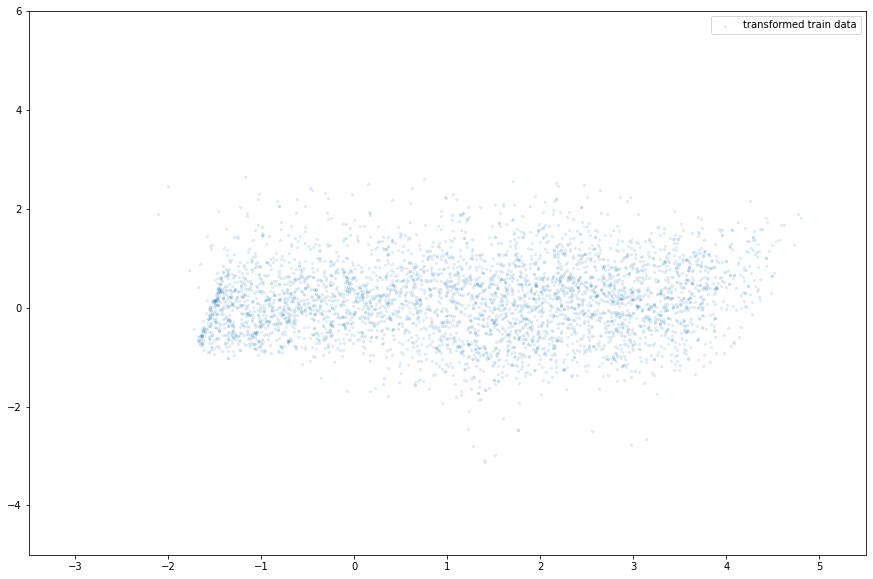

In [29]:
_ = sample_and_plot_from_dataloader(validation_dataloader, config["sp"], scaler, pca, None, None, num_samples=len(expanded_val))

Text(0, 0.5, 'Component 2')

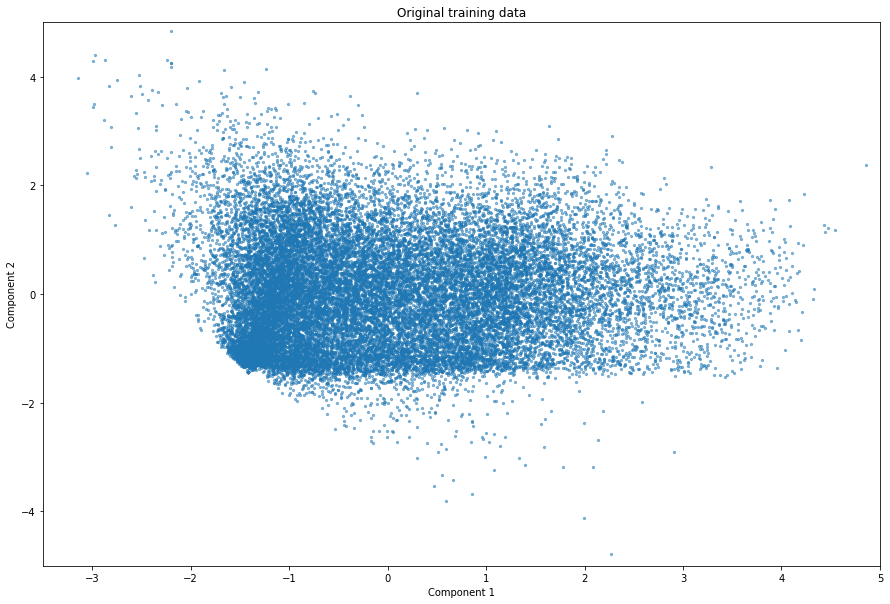

In [30]:
plt.figure(figsize=(15, 10))
plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="test data", s=5, alpha=.5)
plt.title("Original training data")
plt.xlim([-3.5, 5])
plt.ylim([-5, 5])
plt.xlabel("Component 1")
plt.ylabel("Component 2")

Text(0, 0.5, 'Component 2')

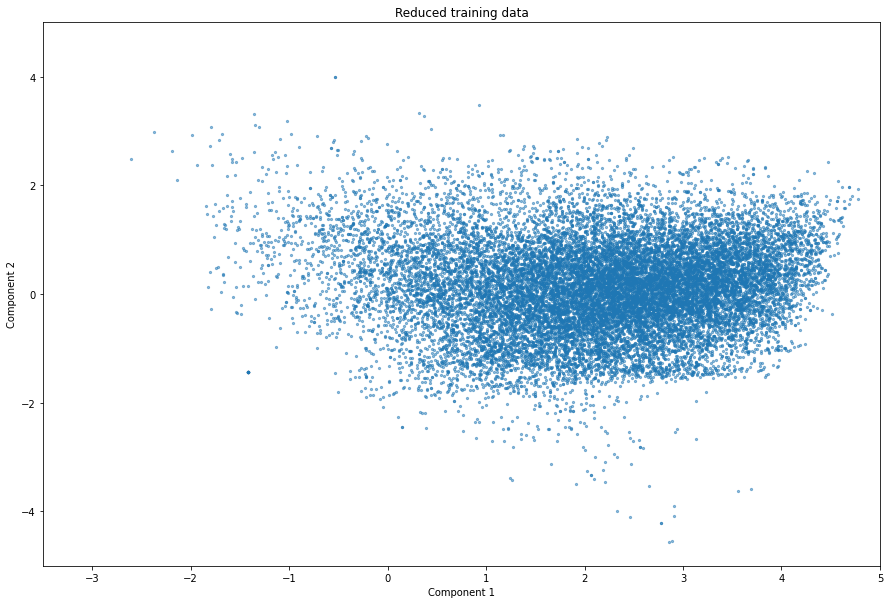

In [31]:
plt.figure(figsize=(15, 10))
plt.scatter(sampled_pca_data[:, 0], sampled_pca_data[:, 1], label="test data", s=5, alpha=.5)
plt.title("Reduced training data")
plt.xlim([-3.5, 5])
plt.ylim([-5, 5])
plt.xlabel("Component 1")
plt.ylabel("Component 2")

Text(0, 0.5, 'Component 2')

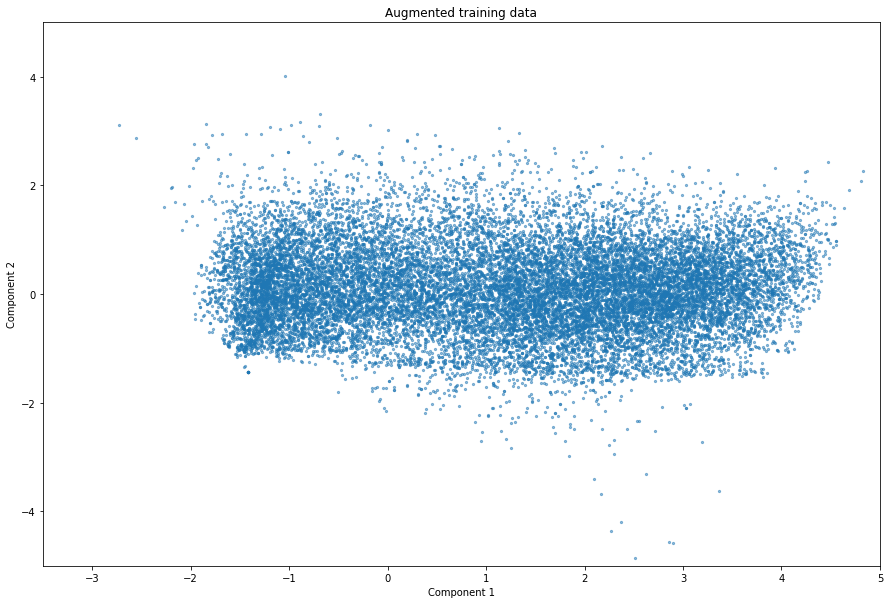

In [32]:
plt.figure(figsize=(15, 10))
plt.scatter(sampled_pca_data2[:, 0], sampled_pca_data2[:, 1], label="test data", s=5, alpha=.5)
plt.title("Augmented training data")
plt.xlim([-3.5, 5])
plt.ylim([-5, 5])
plt.xlabel("Component 1")
plt.ylabel("Component 2")

Text(0, 0.5, 'Component 2')

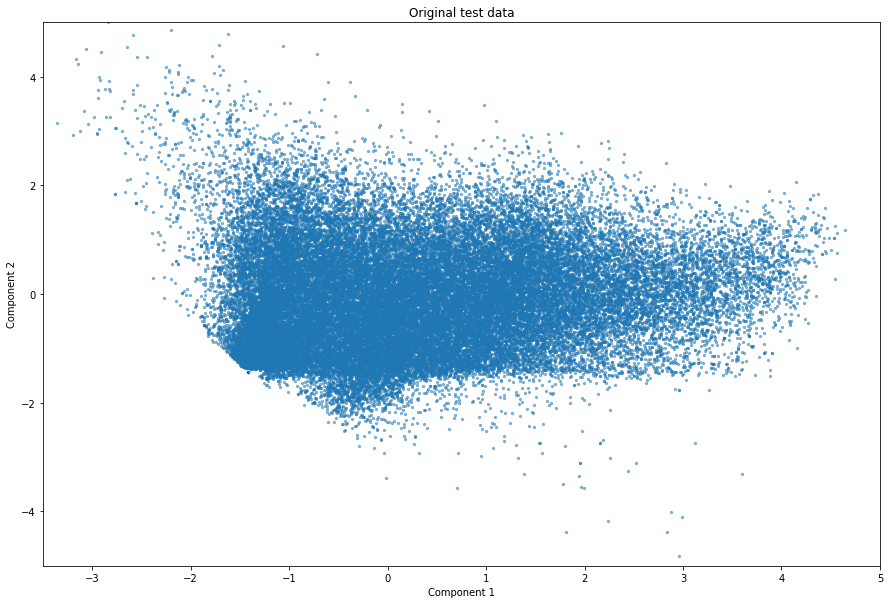

In [33]:
plt.figure(figsize=(15, 10))
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=.5)
plt.title("Original test data")
plt.xlim([-3.5, 5])
plt.ylim([-5, 5])
plt.xlabel("Component 1")
plt.ylabel("Component 2")

In [34]:
ood_mask1 = test_pca_data[:, 0] < 0
ood_mask2 = test_pca_data[:, 1] < 2

ood_mask = np.logical_and(ood_mask1, ood_mask2)

In [35]:
orig_mask = test_pca_data[:, 0] > 0

Text(0, 0.5, 'Component 2')

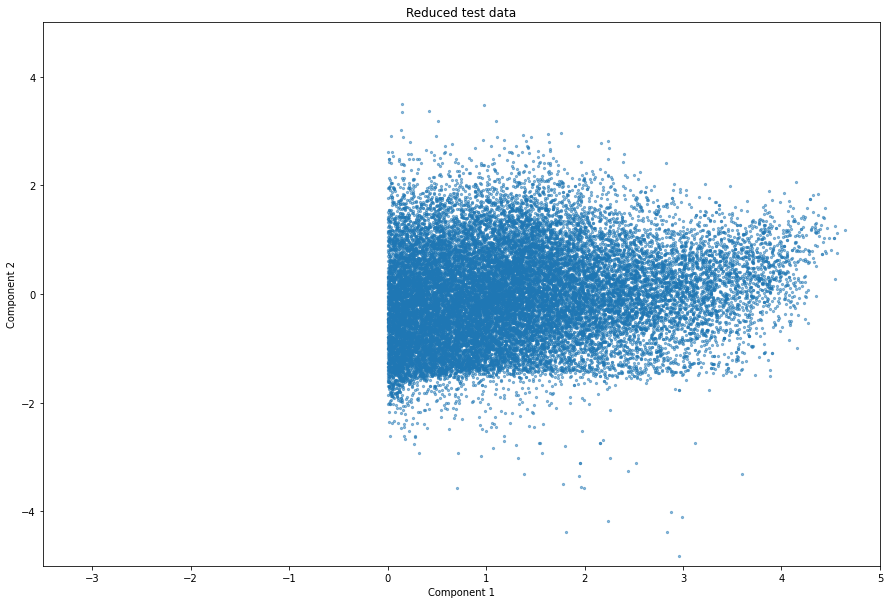

In [36]:
plt.figure(figsize=(15, 10))
plt.scatter(test_pca_data[orig_mask][:, 0], test_pca_data[orig_mask][:, 1], label="test data", s=5, alpha=.5)
plt.title("Reduced test data")
plt.xlim([-3.5, 5])
plt.ylim([-5, 5])
plt.xlabel("Component 1")
plt.ylabel("Component 2")

Text(0, 0.5, 'Component 2')

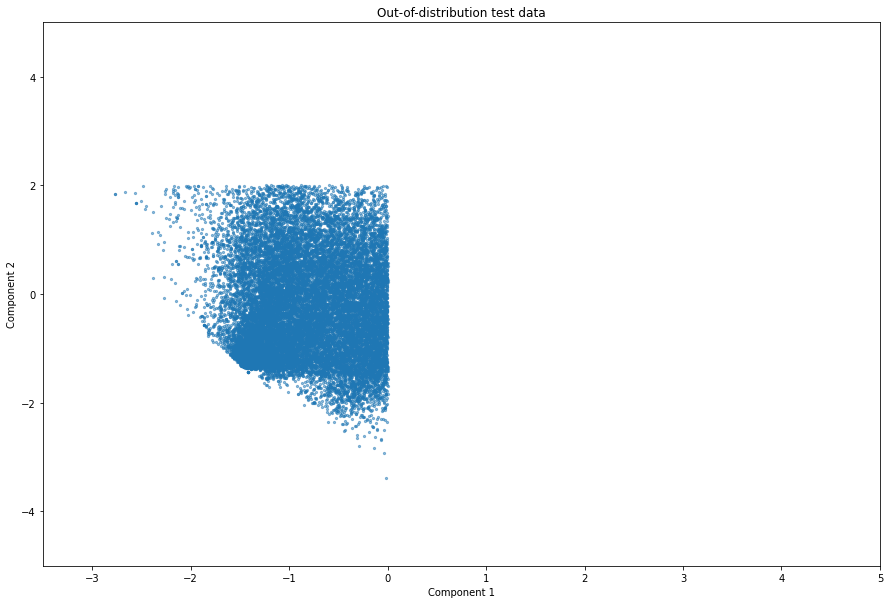

In [37]:
plt.figure(figsize=(15, 10))
plt.scatter(test_pca_data[ood_mask][:, 0], test_pca_data[ood_mask][:, 1], label="test data", s=5, alpha=.5)
plt.title("Out-of-distribution test data")
plt.xlim([-3.5, 5])
plt.ylim([-5, 5])
plt.xlabel("Component 1")
plt.ylabel("Component 2")

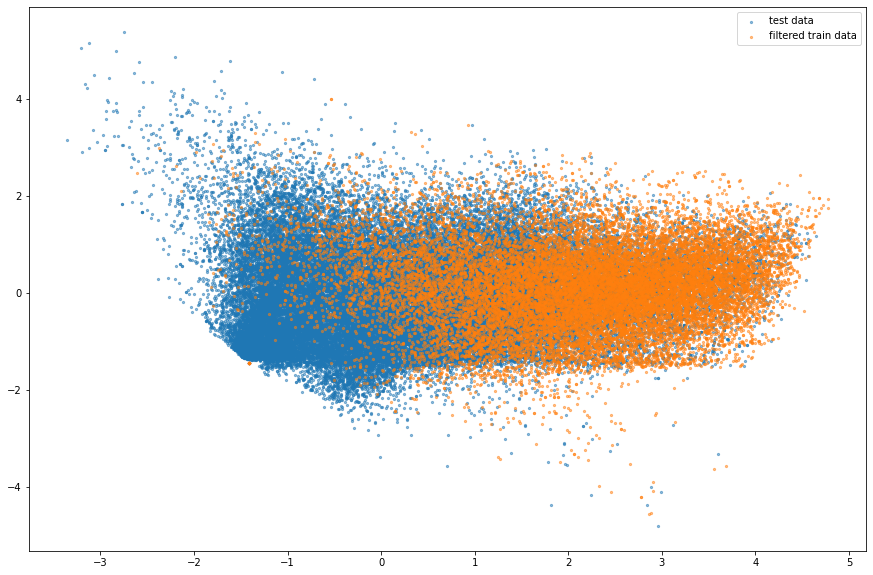

In [38]:
plt.figure(figsize=(15, 10))
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=.5)
plt.scatter(sampled_pca_data[:, 0], sampled_pca_data[:, 1], label="filtered train data", s=5, alpha=.5)
plt.legend()
plt.savefig("ood_reduced.svg")

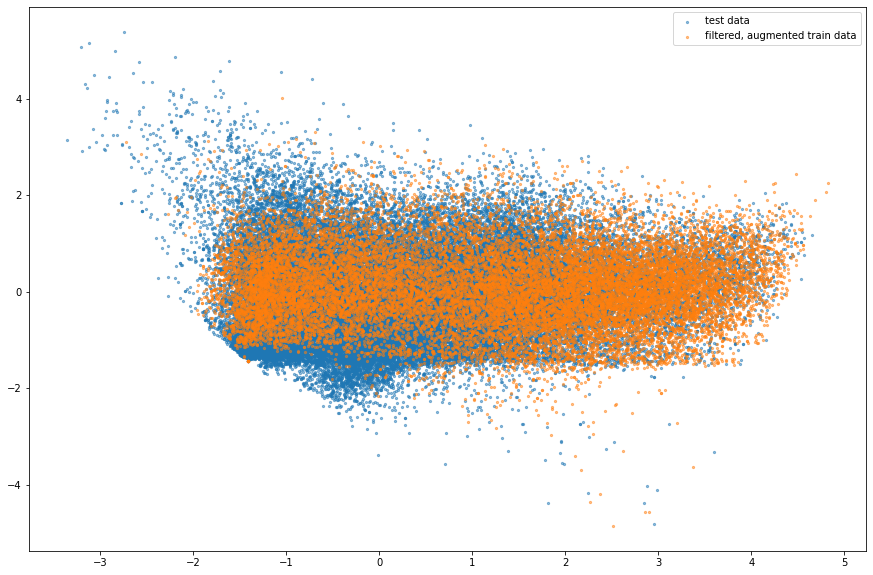

In [39]:
plt.figure(figsize=(15, 10))
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=.5)
plt.scatter(sampled_pca_data2[:, 0], sampled_pca_data2[:, 1], label="filtered, augmented train data", s=5, alpha=.5)
plt.legend()
plt.savefig("ood_reduced_augmented.svg")